# Summarize test results

In [45]:
import pandas as pd
import numpy as np

import scanpy as sc

import scdali
from scdali.utils.stats import apply_fdr_bh, compute_quantile_diff
from scdali.models import SparseGP

import matplotlib.pyplot as plt
import seaborn as sns

In [46]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

## Load data

In [9]:
adata = sc.read('../data/endoderm_ase_processed.h5ad')
adata

AnnData object with n_obs × n_vars = 34254 × 3966
    obs: 'assigned', 'auxDir', 'cell_filter', 'cell_name', 'compatible_fragment_ratio', 'day', 'donor', 'expected_format', 'experiment', 'frag_dist_length', 'gc_bias_correct', 'is_cell_control', 'is_cell_control_bulk', 'is_cell_control_control', 'library_types', 'libType', 'log10_total_counts', 'log10_total_counts_endogenous', 'log10_total_counts_ERCC', 'log10_total_counts_feature_control', 'log10_total_counts_MT', 'log10_total_features', 'log10_total_features_endogenous', 'log10_total_features_ERCC', 'log10_total_features_feature_control', 'log10_total_features_MT', 'mapping_type', 'mates1', 'mates2', 'n_alt_reads', 'n_total_reads', 'num_assigned_fragments', 'num_bias_bins', 'num_bootstraps', 'num_compatible_fragments', 'num_consistent_mappings', 'num_inconsistent_mappings', 'num_libraries', 'num_mapped', 'num_processed', 'num_targets', 'nvars_used', 'pct_counts_endogenous', 'pct_counts_ERCC', 'pct_counts_feature_control', 'pct_counts_

## Compute q-values

In [58]:
for col in adata.var.columns:
    if 'pval' in col and 'orig' not in col:
        adata.var[col.replace('pval', 'qval')] = apply_fdr_bh(adata.var[col])

In [59]:
discoveries = (adata.var[[c for c in adata.var.columns if 'qval' in c]] < 0.1).sum()
discoveries = discoveries[~discoveries.index.str.contains('rnd')] # exclude calibration experiments
discoveries = pd.concat([discoveries, discoveries.index.to_series().str.split('_', expand=True)], 1)

discoveries.columns = ['Discoveries', 'qval', 'Env', 'Model']
discoveries = discoveries.drop('qval', 1).query('Env != "orig"')
discoveries['n_pcs'] = discoveries['Env'].str.replace('pc', '').astype(int)
discoveries['Model'] = discoveries['Model'].replace({'dali': 'scDALI-Het', 'dalirs': 'scDALI-Het\n(with donor ID)'})

In [60]:
discoveries

,Discoveries,Env,Model,n_pcs
qval_pc1_dali,793,pc1,scDALI-Het,1
qval_pc1_dalirs,611,pc1,scDALI-Het\n(with donor ID),1
qval_pc2_dali,908,pc2,scDALI-Het,2
qval_pc2_dalirs,715,pc2,scDALI-Het\n(with donor ID),2
qval_pc3_dali,1116,pc3,scDALI-Het,3
qval_pc3_dalirs,779,pc3,scDALI-Het\n(with donor ID),3
qval_pc4_dali,1275,pc4,scDALI-Het,4
qval_pc4_dalirs,813,pc4,scDALI-Het\n(with donor ID),4
qval_pc5_dali,1332,pc5,scDALI-Het,5
qval_pc5_dalirs,801,pc5,scDALI-Het\n(with donor ID),5


## Plot

In [61]:
plot_final = True

OUT_RC_PARAMS = {'font.size': 8, 'figure.figsize': (2.8, 2.3)} if plot_final else {}
for k, v in OUT_RC_PARAMS.items():
    plt.rcParams[k] = v

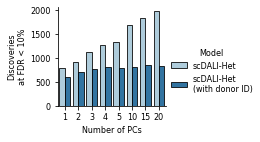

In [70]:
g = sns.catplot(kind='bar',
    x='n_pcs', y='Discoveries', 
    hue='Model', data=discoveries, 
    palette=sns.color_palette("Paired")[:2],
    height=0.8*plt.rcParams['figure.figsize'][1], aspect=2.5/2, 
    edgecolor='black', linewidth=.8)
g.set(ylabel='Discoveries\nat FDR < 10%', xlabel='Number of PCs')
sns.despine()
if plot_final:
    plt.savefig('plots/discoveries_by_nenv.svg')

In [63]:
N_PCS = 10

/icgc/dkfzlsdf/analysis/B260/users/heinent/envs/f1_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


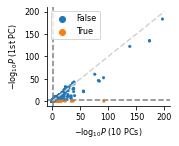

In [90]:
df = -np.log10(adata.var[[f'pval_pc{N_PCS}_dalirs', f'pval_pc1_dalirs']])
hue = (adata.var[f'qval_pc{N_PCS}_dalirs'] < 0.1) & (adata.var[f'qval_pc1_dalirs'] > 0.1)

fdr_x = adata.var.query(f'qval_pc{N_PCS}_dalirs < 0.1')[f'pval_pc{N_PCS}_dalirs'].max()
fdr_y = adata.var.query(f'qval_pc1_dalirs < 0.1')[f'pval_pc1_dalirs'].max()

#sns.set_style("white")
fig, ax = plt.subplots(figsize=(0.9 * plt.rcParams['figure.figsize'][0], 0.9*plt.rcParams['figure.figsize'][1]))
sns.scatterplot(
    x=f'pval_pc{N_PCS}_dalirs',
    y=f'pval_pc1_dalirs',
    data=df, 
    hue=hue,
    edgecolor=None, s=8, 
    ax=ax, rasterized=True)
ax.plot([0, 200], [0, 200], linestyle='--', color='lightgrey')

ax.axvline(-np.log10(fdr_x), c='grey', linestyle='--')
ax.axhline(-np.log10(fdr_y), c='grey', linestyle='--')

ax.set(xlabel='$-\log_{10} P$ (%d PCs)' % N_PCS, ylabel='$-\log_{10} P$ (1st PC)')
sns.despine()
plt.tight_layout()

if plot_final:
    plt.savefig(f'plots/pvals_time_vs_pc{N_PCS}.svg', dpi=300)

In [17]:
from itertools import product

In [82]:
cmp = ['< 0.1', '> 0.1']
for x, y in product(cmp, cmp):
    ids = adata.var.query(f'qval_pc{N_PCS}_dalirs {x} and qval_pc1_dalirs {y}').index
    print(f'PC{N_PCS} {x} and PC1 {y}' + ': %d. Mean P (PC1): %.2f, (PC%d): %.2f' % (ids.size, adata.var.loc[ids, f'pval_pc1_dalirs'].mean(), N_PCS, adata.var.loc[ids, f'pval_pc{N_PCS}_dalirs'].mean()))

PC10 < 0.1 and PC1 < 0.1: 463. Mean P (PC1): 0.00, (PC10): 0.00
PC10 < 0.1 and PC1 > 0.1: 349. Mean P (PC1): 0.28, (PC10): 0.01
PC10 > 0.1 and PC1 < 0.1: 148. Mean P (PC1): 0.01, (PC10): 0.10
PC10 > 0.1 and PC1 > 0.1: 3006. Mean P (PC1): 0.45, (PC10): 0.42


In [19]:
148 / 611, 349 / 812

(0.24222585924713586, 0.42980295566502463)

In [20]:
ids = adata.var.query(f'qval_pc{N_PCS}_dalirs < 0.01 and qval_pc1_dalirs > 0.2').index

In [21]:
def get_cell_states(N_PCS):
    E = adata.obsm['X_pca'][:, :N_PCS]
    return E / np.sqrt(np.var(E, 0))

In [22]:
A = adata[:, ids].X.A
D = adata[:, ids].layers['allelic_total'].A
E = get_cell_states(N_PCS)

/icgc/dkfzlsdf/analysis/B260/users/heinent/envs/f1_analysis/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [23]:
rate_posterior = scdali.run_scdali(A=A, D=D, model='GP', cell_state=E, n_cores=10)

[scdali] Processing 101 regions on 10 core(s) ... 


100%|██████████| 10/10 [35:06<00:00, 210.62s/it]  


In [24]:
rate_means = pd.DataFrame(rate_posterior['posterior_mean'], columns=ids, index=adata.obs_names) 
rate_vars = pd.DataFrame(rate_posterior['posterior_mean'], columns=ids, index=adata.obs_names) 

In [25]:
rate_means.to_csv('../data/posterior_mean.csv')
rate_vars.to_csv('../data/posterior_vars.csv')

## Visualize

In [28]:
rate_means = pd.read_csv('../data/posterior_mean.csv', index_col=0)
rate_vars = pd.read_csv('../data/posterior_vars.csv', index_col=0)

In [30]:
group_means = rate_means.copy()
group_means['leiden'] = adata.obs['leiden']
group_means = group_means.groupby('leiden').mean()

In [31]:
qdiffs = compute_quantile_diff(rate_means, q=0.1)

/icgc/dkfzlsdf/analysis/B260/users/heinent/envs/f1_analysis/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


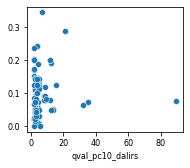

In [32]:
sns.scatterplot(x=-np.log10(adata[:, ids].var[f'qval_pc{N_PCS}_dalirs']), y=qdiffs)

In [33]:
ids_filtered = np.where(qdiffs > 0.15)
ids_filtered

(array([ 2, 11, 17, 28, 43, 50, 51, 57, 59, 66, 68, 77, 89, 97, 98]),)

In [34]:
rate_means.columns[ids_filtered]

Index(['ENSG00000206503-6_29812578_C_A', 'ENSG00000186439-6_123904601_C_T',
       'ENSG00000186439-6_123897071_C_T', 'ENSG00000196126-6_32604969_A_G',
       'ENSG00000160284-21_47649802_G_C', 'ENSG00000160284-21_47645970_G_C',
       'ENSG00000112667-6_43217239_G_C', 'ENSG00000069482-11_68353008_T_C',
       'ENSG00000125447-17_73192415_C_T', 'ENSG00000138757-4_76593147_C_A',
       'ENSG00000214078-20_34344225_T_A', 'ENSG00000137267-6_3144028_A_G',
       'ENSG00000137267-6_3144805_G_T', 'ENSG00000160256-21_46378941_G_A',
       'ENSG00000177685-11_837772_C_T'],
      dtype='object')

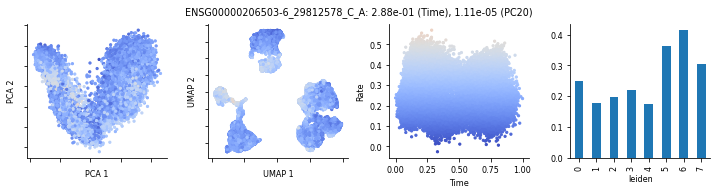

<Figure size 201.6x165.6 with 0 Axes>

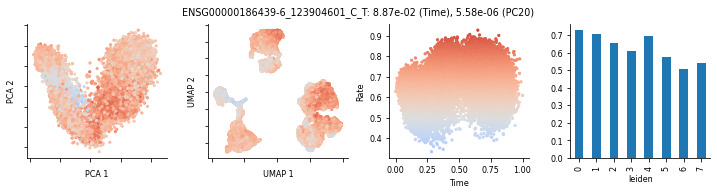

<Figure size 201.6x165.6 with 0 Axes>

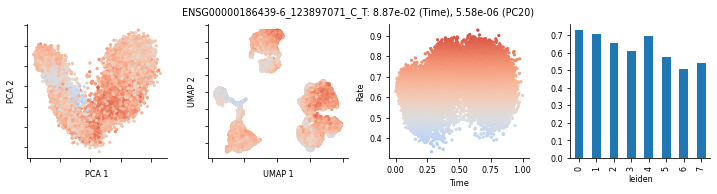

<Figure size 201.6x165.6 with 0 Axes>

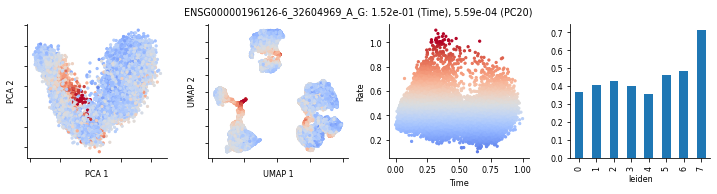

<Figure size 201.6x165.6 with 0 Axes>

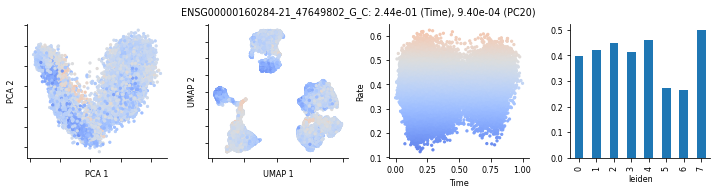

<Figure size 201.6x165.6 with 0 Axes>

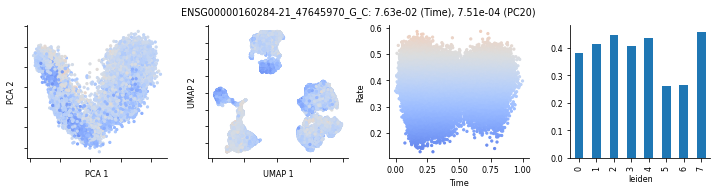

<Figure size 201.6x165.6 with 0 Axes>

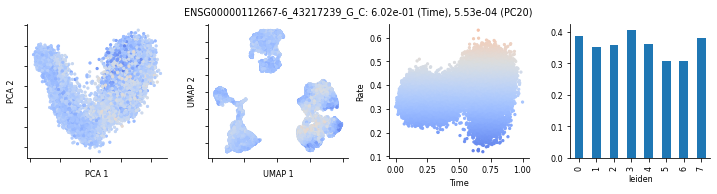

<Figure size 201.6x165.6 with 0 Axes>

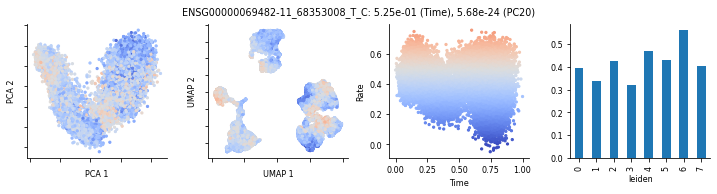

<Figure size 201.6x165.6 with 0 Axes>

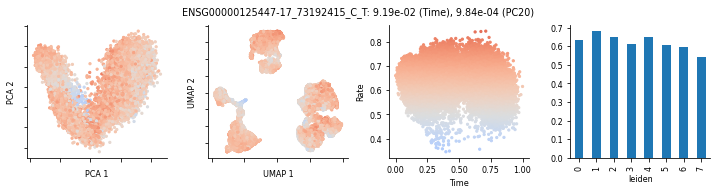

<Figure size 201.6x165.6 with 0 Axes>

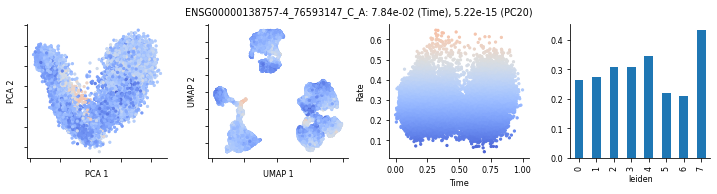

<Figure size 201.6x165.6 with 0 Axes>

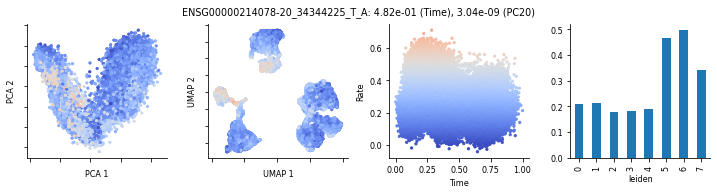

<Figure size 201.6x165.6 with 0 Axes>

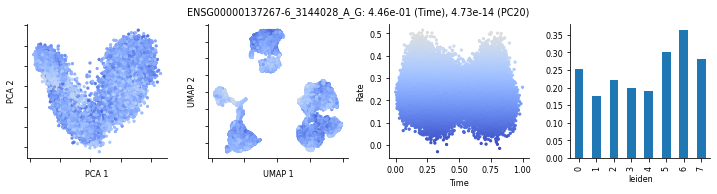

<Figure size 201.6x165.6 with 0 Axes>

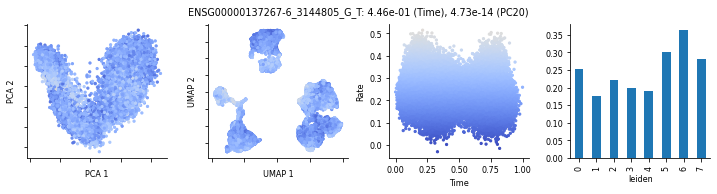

<Figure size 201.6x165.6 with 0 Axes>

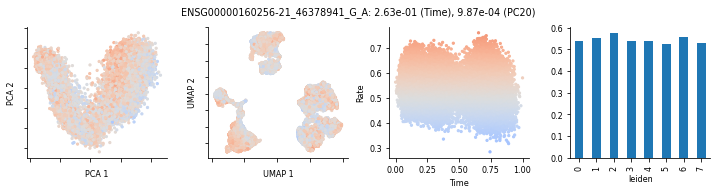

<Figure size 201.6x165.6 with 0 Axes>

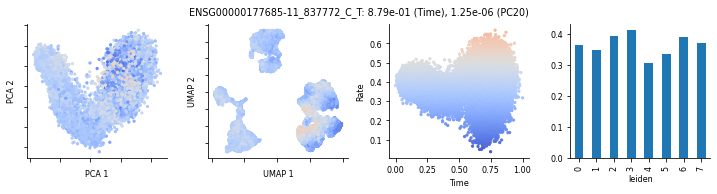

<Figure size 201.6x165.6 with 0 Axes>

In [37]:
for c in rate_means.columns[ids_filtered]:
    fig, axes = plt.subplots(1, 4, figsize=(10, 2.5))
    
    ax = axes[0]
    ax.scatter(
        x=adata.obsm['X_pca'][:, 0],
        y=adata.obsm['X_pca'][:, 1],
        c=rate_means[c],
        edgecolor=None, s=5,
        rasterized=True,
        vmin=0, vmax=1, cmap=plt.cm.coolwarm)
    ax.set(xlabel='PCA 1', ylabel='PCA 2', xticklabels=[], yticklabels=[])
    
    ax = axes[1]
    ax.scatter(
        x=adata.obsm['X_umap'][:, 0],
        y=adata.obsm['X_umap'][:, 1],
        c=rate_means[c],
        edgecolor=None, s=5,
        rasterized=True,
        vmin=0, vmax=1, cmap=plt.cm.coolwarm)
    ax.set(xlabel='UMAP 1', ylabel='UMAP 2', xticklabels=[], yticklabels=[])

    ax = axes[2]
    ax.scatter(
        x=adata.obs['pseudo'],
        y=rate_means[c],
        c=rate_means[c],
        edgecolor=None, s=5,
        rasterized=True,
        vmin=0, vmax=1, cmap=plt.cm.coolwarm)
    ax.set(xlabel='Time', ylabel='Rate')
    ax = axes[3]
    group_means[c].plot.bar(ax=ax)
    
    sns.despine()

    
    fig.suptitle('%s: %.2e (Time), %.2e (PC20)' % (c, adata.var.loc[c, 'pval_pc1_dalirs'], adata.var.loc[c, f'pval_pc{N_PCS}_dalirs']), y=1.05)
    plt.tight_layout()
    plt.show()
    
    if plot_final:
        plt.gcf().savefig('plots/%s_rates.svg' % k, dpi=300)

In [42]:
example_gene = 'ENSG00000214078-20_34344225_T_A'

effect size

In [43]:
qdiffs[np.where(ids == example_gene)[0]]

array([0.34317796])

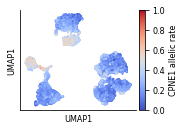

In [80]:
fig, ax = plt.subplots(figsize=(.8 * plt.rcParams['figure.figsize'][0], .8*plt.rcParams['figure.figsize'][1]))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

im = ax.scatter(
    x=adata.obsm['X_umap'][:, 0],
    y=adata.obsm['X_umap'][:, 1],
    c=rate_means[example_gene], rasterized=True,
    s=1, cmap=sns.color_palette('coolwarm', as_cmap=True), vmin=0, vmax=1)
ax.set(xticklabels=[], xticks=[], yticklabels=[], yticks=[], xlabel='UMAP1', ylabel='UMAP1');

fig.colorbar(im, cax=cax, orientation='vertical', label='CPNE1 allelic rate')
sns.despine()

if plot_final:
    plt.savefig('plots/umap_CPNE1_ase.svg', dpi=300)